In [34]:
import figure_functions
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
import scipy

import pynumdiff
import figurefirst as fifi
import figure_functions as ff

from process_trajectory import Trajectory, run_process

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load fly dataset

In [35]:
data_path = os.path.join(os.path.pardir, 'data', 'processed', 'laminar_orco_flash' + '.csv')
processed_traj = pd.read_csv(data_path)
processed_traj

,ID,time,pulse,w,zeta,position_x,position_y,position_z,velocity_x,velocity_y,...,psi,v_para,v_perp,a_para,a_perp,a,gamma,gdot,phidot,phi2dot
0,0,-0.10,False,0.4,3.141593,0.000000,0.000000,0.000000,0.056356,-0.103143,...,0.0,0.117536,0.0,0.309329,0.351020,0.467867,0.848450,-0.438153,3.997432,289.355905
1,0,-0.09,False,0.4,3.141593,0.000531,-0.001072,-0.000955,0.058260,-0.097017,...,0.0,0.113166,0.0,0.319094,0.342919,0.468417,0.821371,-0.697056,6.817545,244.304471
2,0,-0.08,False,0.4,3.141593,0.001164,-0.001968,-0.001938,0.061578,-0.083304,...,0.0,0.103592,0.0,0.341362,0.321661,0.469035,0.755693,-0.956995,8.878587,-107.370041
3,0,-0.07,False,0.4,3.141593,0.001811,-0.002656,-0.003025,0.061877,-0.070799,...,0.0,0.094028,0.0,0.357255,0.301183,0.467271,0.700444,-0.889952,4.675464,-553.038289
4,0,-0.06,False,0.4,3.141593,0.002397,-0.003340,-0.004062,0.057223,-0.063921,...,0.0,0.085792,0.0,0.352590,0.298026,0.461669,0.701729,-0.770006,-2.187861,-614.491847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50137,121,3.96,False,0.4,3.141593,0.094042,0.003425,-0.170928,0.111780,0.405884,...,0.0,0.420995,0.0,0.527201,-0.385643,0.653193,-0.631550,0.999351,15.228659,114.064928
50138,121,3.97,False,0.4,3.141593,0.094833,0.007639,-0.170034,0.048046,0.430356,...,0.0,0.433030,0.0,0.477411,-0.397530,0.621250,-0.694352,1.186321,15.467288,-86.764825
50139,121,3.98,False,0.4,3.141593,0.094995,0.012080,-0.169171,-0.017960,0.444290,...,0.0,0.444653,0.0,0.428496,-0.399674,0.585959,-0.750609,1.040266,13.483731,-363.181453
50140,121,3.99,False,0.4,3.141593,0.094644,0.016554,-0.168002,-0.071713,0.448215,...,0.0,0.453916,0.0,0.390721,-0.394977,0.555580,-0.790814,0.663549,8.214859,-448.157870


In [36]:
# Put individual trajectories into list
trajID = np.unique(processed_traj.ID)
traj_list = []
for id in trajID:
    traj_index = np.where(processed_traj.ID == id)[0]
    traj = processed_traj.iloc[traj_index, :]
    traj_list.append(traj)

In [37]:
traj_list[0]

,ID,time,pulse,w,zeta,position_x,position_y,position_z,velocity_x,velocity_y,...,psi,v_para,v_perp,a_para,a_perp,a,gamma,gdot,phidot,phi2dot
0,0,-0.10,False,0.4,3.141593,0.000000,0.000000,0.000000,0.056356,-0.103143,...,0.0,0.117536,0.0,0.309329,0.351020,0.467867,0.848450,-0.438153,3.997432,289.355905
1,0,-0.09,False,0.4,3.141593,0.000531,-0.001072,-0.000955,0.058260,-0.097017,...,0.0,0.113166,0.0,0.319094,0.342919,0.468417,0.821371,-0.697056,6.817545,244.304471
2,0,-0.08,False,0.4,3.141593,0.001164,-0.001968,-0.001938,0.061578,-0.083304,...,0.0,0.103592,0.0,0.341362,0.321661,0.469035,0.755693,-0.956995,8.878587,-107.370041
3,0,-0.07,False,0.4,3.141593,0.001811,-0.002656,-0.003025,0.061877,-0.070799,...,0.0,0.094028,0.0,0.357255,0.301183,0.467271,0.700444,-0.889952,4.675464,-553.038289
4,0,-0.06,False,0.4,3.141593,0.002397,-0.003340,-0.004062,0.057223,-0.063921,...,0.0,0.085792,0.0,0.352590,0.298026,0.461669,0.701729,-0.770006,-2.187861,-614.491847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0,3.96,False,0.4,3.141593,0.304212,0.032515,-0.016340,-0.027844,-0.320330,...,0.0,0.321537,0.0,0.286899,0.398497,0.491030,0.946806,-0.690405,-0.080784,168.397913
407,0,3.97,False,0.4,3.141593,0.303980,0.029270,-0.015838,-0.024583,-0.313407,...,0.0,0.314370,0.0,0.283091,0.398775,0.489042,0.953457,-1.028364,1.172136,75.282576
408,0,3.98,False,0.4,3.141593,0.303724,0.026190,-0.015360,-0.019074,-0.300352,...,0.0,0.300957,0.0,0.275605,0.399196,0.485093,0.966542,-1.454358,1.436793,-6.745090
409,0,3.99,False,0.4,3.141593,0.303547,0.023250,-0.014913,-0.014075,-0.284951,...,0.0,0.285298,0.0,0.265564,0.399513,0.479724,0.984143,-1.140634,1.023129,-37.555090


# Plot one trajectory

In [38]:
traj = traj_list[1]
traj

,ID,time,pulse,w,zeta,position_x,position_y,position_z,velocity_x,velocity_y,...,psi,v_para,v_perp,a_para,a_perp,a,gamma,gdot,phidot,phi2dot
411,1,-0.10,False,0.4,3.141593,0.000000,0.000000,0.000000,0.229801,-0.271108,...,0.0,0.355398,0.0,0.614039,0.305132,0.685674,0.461185,0.642146,1.729763,103.917841
412,1,-0.09,False,0.4,3.141593,0.002250,-0.002714,0.001287,0.238469,-0.271731,...,0.0,0.361532,0.0,0.625375,0.300644,0.693888,0.448123,1.145565,2.770160,96.896954
413,1,-0.08,False,0.4,3.141593,0.004765,-0.005437,0.002412,0.260195,-0.274572,...,0.0,0.378274,0.0,0.653413,0.290342,0.715015,0.418143,1.999935,3.669757,-1.441818
414,1,-0.07,False,0.4,3.141593,0.007520,-0.008204,0.003435,0.286296,-0.281583,...,0.0,0.401565,0.0,0.686745,0.280486,0.741816,0.387751,2.439018,2.739641,-120.044188
415,1,-0.06,False,0.4,3.141593,0.010506,-0.011057,0.004287,0.310258,-0.293407,...,0.0,0.427022,0.0,0.717647,0.274840,0.768475,0.365743,2.479364,1.270134,-123.759350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,1,3.96,False,0.4,3.141593,0.286500,-0.057410,-0.186815,-0.160531,0.256995,...,0.0,0.303012,0.0,0.091099,-0.339253,0.351272,-1.308458,4.919504,3.057337,-224.986589
818,1,3.97,False,0.4,3.141593,0.284683,-0.054598,-0.185813,-0.189634,0.289392,...,0.0,0.345989,0.0,0.126753,-0.334567,0.357773,-1.208649,3.505614,1.860088,-90.168262
819,1,3.98,False,0.4,3.141593,0.282712,-0.051576,-0.184805,-0.209117,0.309045,...,0.0,0.373147,0.0,0.148981,-0.331285,0.363243,-1.148187,2.049048,1.203684,-59.162253
820,1,3.99,False,0.4,3.141593,0.280528,-0.048472,-0.183945,-0.220061,0.318275,...,0.0,0.386944,0.0,0.159458,-0.329014,0.365619,-1.119500,0.893257,0.736448,-22.237234


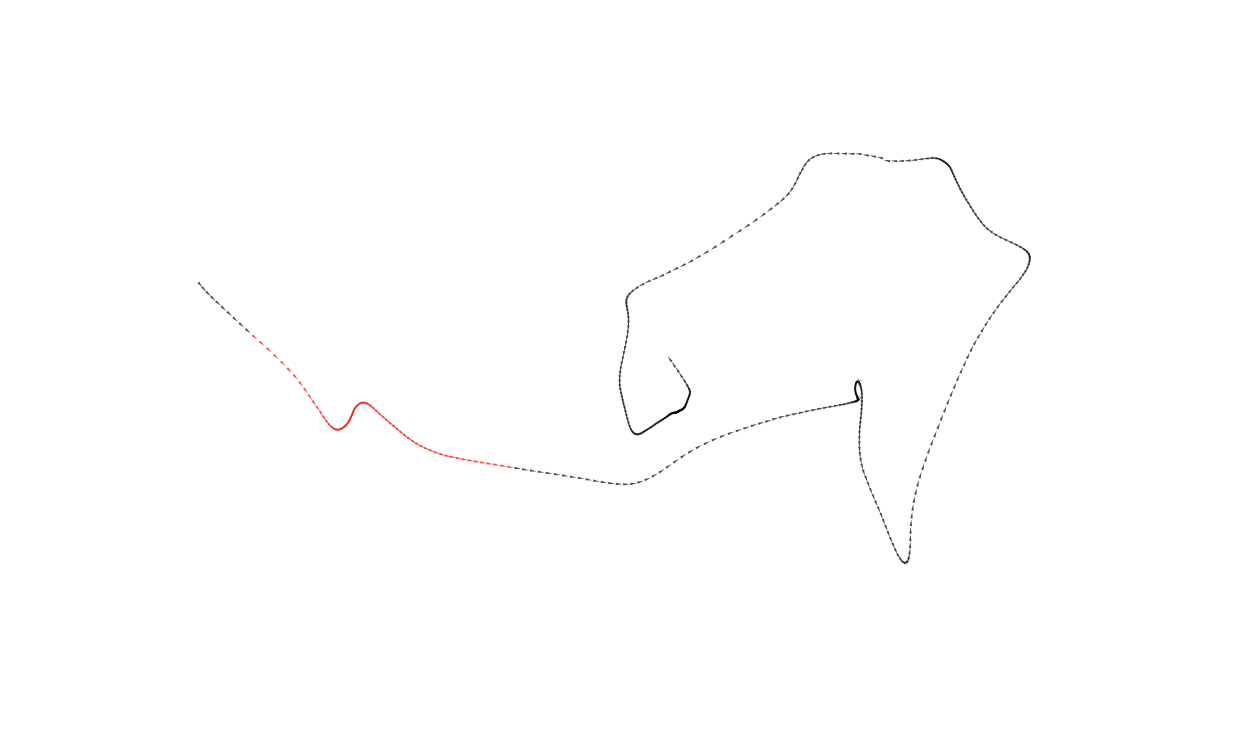

In [39]:
cmap_pulse = ListedColormap(np.array([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ff.plot_trajectory(traj.position_x.values,
                   traj.position_y.values,
                   traj.phi.values,
                   traj.pulse.values,
                   colormap=cmap_pulse,
                   ax=ax, size_radius=0.004, nskip=0, alpha=0.7)

fifi.mpl_functions.adjust_spines(ax, [])

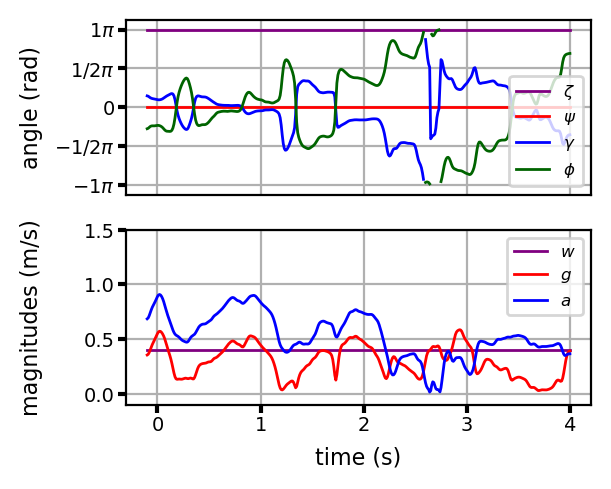

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(3, 2.5), dpi=200)

ax[0].plot(*ff.circplot(traj.time, traj.zeta.values), label='$\zeta$', linewidth=1.0, color='purple')
ax[0].plot(*ff.circplot(traj.time, traj.psi.values), label='$\psi$', linewidth=1.0, color='red')
ax[0].plot(*ff.circplot(traj.time, traj.gamma.values), label='$\gamma$', linewidth=1.0, color='blue')
ax[0].plot(*ff.circplot(traj.time, traj.phi.values), label='$\phi$', linewidth=1.0, color='darkgreen')

ax[1].plot(traj.time, traj.w, label='$w$', linewidth=1.0, color='purple')
ax[1].plot(traj.time, traj.g, label='$g$', linewidth=1.0, color='red')
ax[1].plot(traj.time, traj.a, label='$a$', linewidth=1.0, color='blue')

ff.pi_yaxis(ax[0])
ax[0].set_ylabel('angle (rad)', fontsize=8)
ax[0].legend(fontsize=6)

ax[1].set_ylim(-0.1, 1.5)
ax[1].set_ylabel('magnitudes (m/s)', fontsize=8)
ax[1].legend(fontsize=6)

ax[1].set_xlabel('time (s)', fontsize=8)

for a in ax:
    a.grid()
    a.tick_params(axis='both', which='major', labelsize=7, pad=1.0, width=1.5, length=3, left=True, bottom=True)
 
ax[0].tick_params(axis='x', labelbottom=False, bottom=False)   
fig.align_ylabels(ax)

# Plot many trajectories

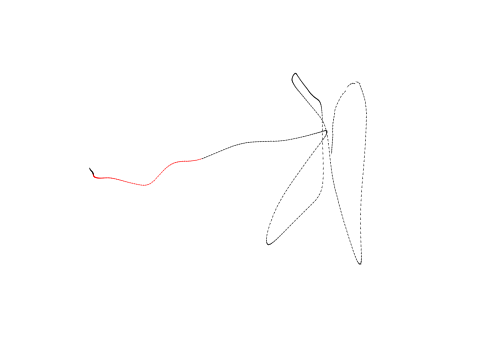

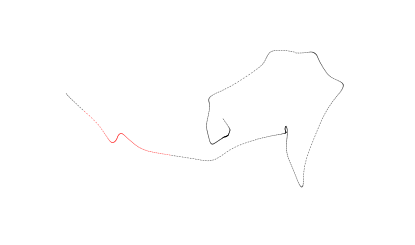

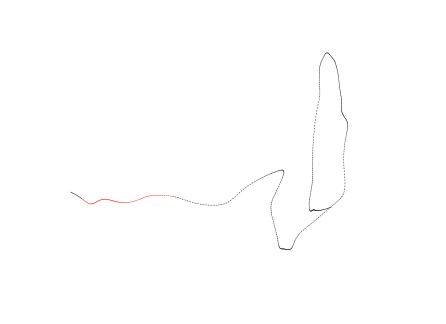

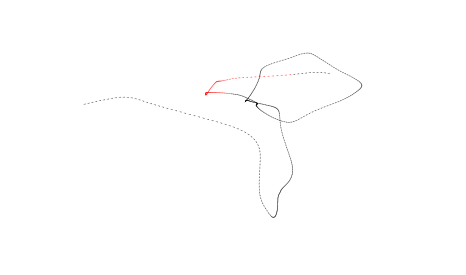

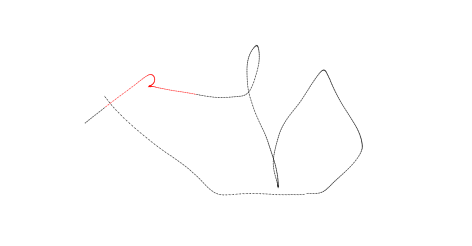

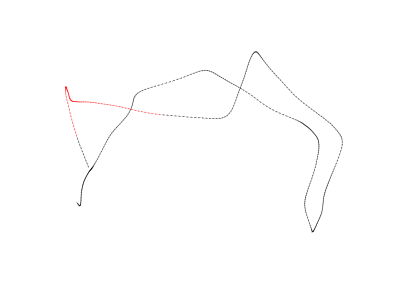

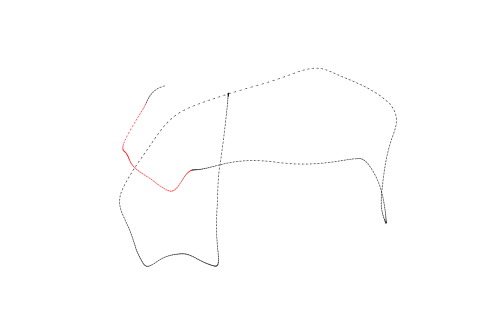

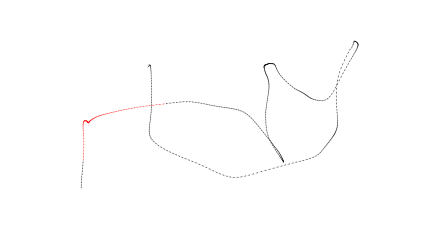

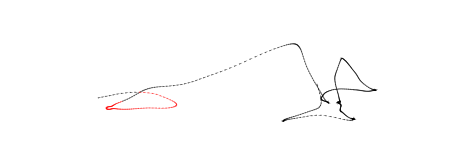

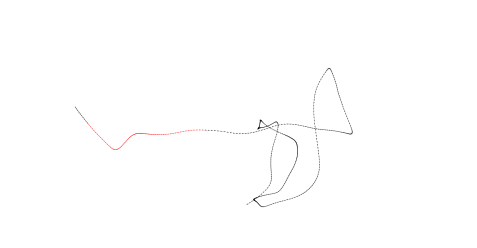

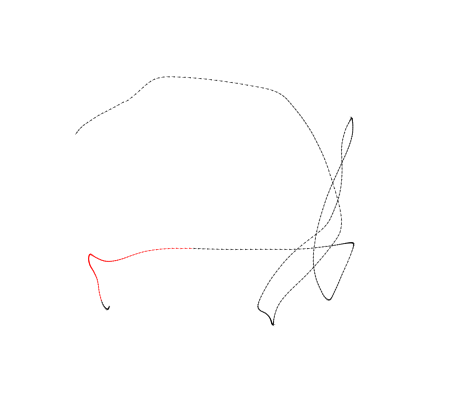

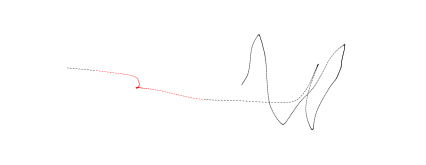

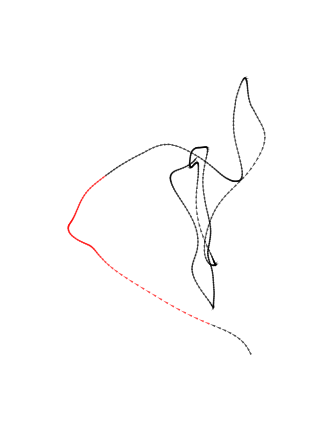

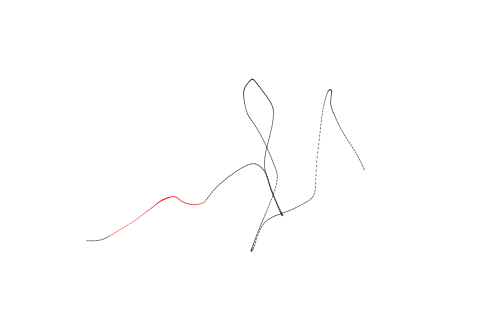

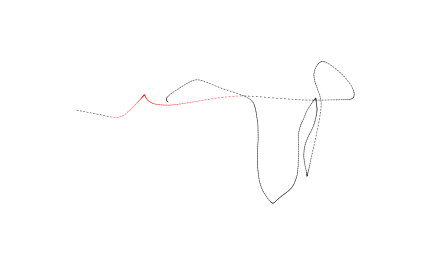

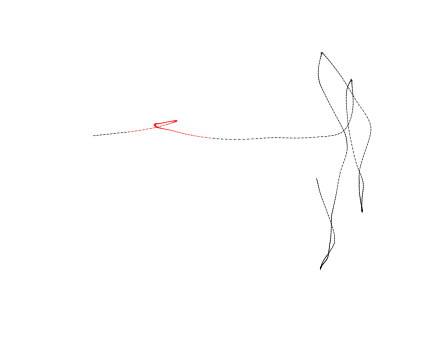

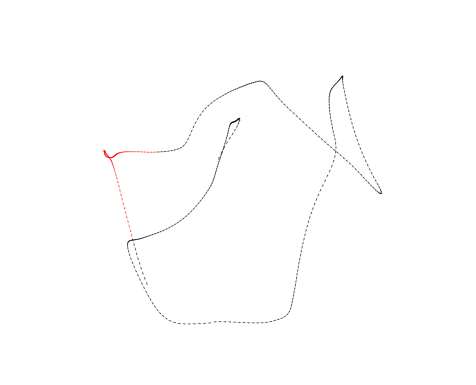

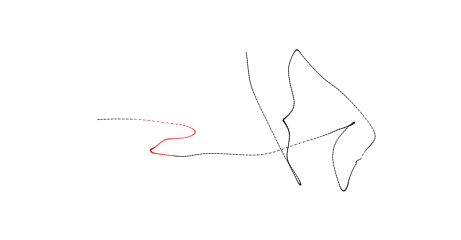

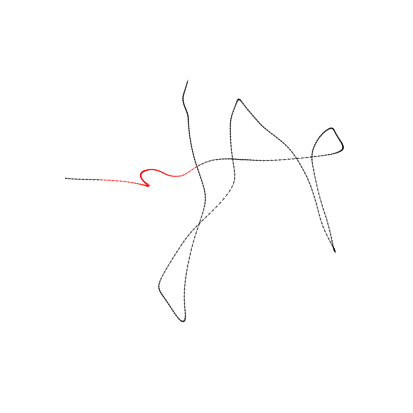

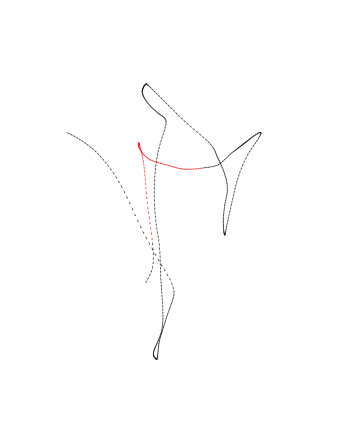

In [41]:
for traj in traj_list[0:20]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    ff.plot_trajectory(traj.position_x.values,
                       traj.position_y.values,
                       traj.phi.values,
                       traj.pulse.values,
                       colormap=cmap_pulse,
                       ax=ax, size_radius=0.004, nskip=0, alpha=0.7)
    
    fifi.mpl_functions.adjust_spines(ax, [])